<a href="https://colab.research.google.com/github/Prabha-krish/Dissertation/blob/main/preprocessing%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading HR Dataset

In [ ]:
#mounting HR dataset into Google Colab
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Project/Colab Notebooks/merged_HRdata"


Mounted at /content/drive
/content/drive/MyDrive/Project/Colab Notebooks/merged_HRdata


In [ ]:
# reading  HR
#import below libraries
import os   # to work with file paths & directories
import cv2  # image processing
import re   # regular expression matching

# to sort the images in alpha numeric order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def preprocess_images(images, target_size):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        resized_images.append(resized_image_rgb)
    return resized_images

path_HR = '/content/drive/MyDrive/Project/Colab Notebooks/merged_HRdata'

HR_files = sorted_alphanumeric(os.listdir(path_HR))
# reading images
# array to store images
images_HR = []


for file_HR in HR_files:
    if file_HR == '1756.jpg':
        break

    image_path_HR = os.path.join(path_HR, file_HR)
    HR_image = cv2.imread(image_path_HR)
    if HR_image is not None:
        images_HR.append(HR_image)
target_size = (256, 256)
resized_images_HR= preprocess_images(images_HR, target_size)


# EDA for HR images

In [ ]:
# 1) checking image size of orignal HR images
height, width, _ = HR_image.shape
HR_image.shape

# 256 * 256 image with 3 channels (RGB)

(256, 256, 3)

In [ ]:
import numpy as np

HR_images = np.array(resized_images_HR)
height, width, channels = HR_images.shape[:3]
HR_images.shape


(1755, 256, 256, 3)

In [ ]:
# to print all the images size
#for HR_image, filename in zip(images_HR, files):

    #height, width, _ = HR_image.shape
    #print(f"Image size: {filename} - Size: {width} x {height}")

In [ ]:
# 2) image statistics
#image Statistics for HR image as whole dataset if we want we can calculate for each images from ds
import numpy as np

all_images = np.stack(resized_images_HR, axis=0)

# calculate mean, sd
mean_image = np.mean(all_images, axis=(0, 1, 2))
std_image = np.std(all_images, axis=(0, 1, 2))

print("HR images statistics")
print("Mean for HR:", mean_image)
print("Std for HR:", std_image)

HR images statistics
Mean for HR: [111.67108026 111.02088918 106.01584041]
Std for HR: [72.25712697 68.90563649 73.69645012]


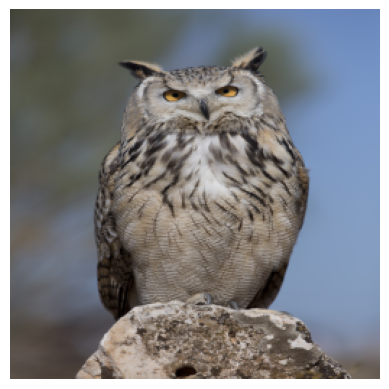

In [ ]:
# 3) visual inspection - manually checking the quality
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
image = resized_images_HR[879]
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
# 3) calculating Spatial Resoultion for whole ds
pixel_size = 1

total_edgecount = 0
total_imagecount = 0

block_size = 13
constant_offset = 2

for image in resized_images_HR:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    edge = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, constant_offset)
    edge_count = cv2.countNonZero(edge)

    total_edgecount += edge_count
    total_imagecount += 1


    average_spatial_resolution = (total_edgecount / total_imagecount) / resized_images_HR[0].shape[0] * pixel_size

print("Average Spatial Resolution of HR images:", average_spatial_resolution)



Average Spatial Resolution of HR images: 153.2779046474359


In [ ]:
# 3) Spatial Resoultion for particular image

image1 = resized_images_HR[879]
pixel_size = 1
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
def calculate_spatial_resolution(image1, pixel_size):

    edges = cv2.Canny(gray_image1, 100, 200)
    edge_count = cv2.countNonZero(edges)
    image_height = image1.shape[0]
    spatial_resolution = (edge_count / image_height) * pixel_size

    return spatial_resolution


spatial_resolution = calculate_spatial_resolution(image1, pixel_size)

print("Spatial Resolution of image 879 from image array:", spatial_resolution)


Spatial Resolution of image 879 from image array: 29.23828125


In [ ]:
#4) Nosie analysis for image 879
import numpy as np
import cv2

def calculate_noise(image1):

  Mean = np.mean(gray_image1)
  SD = np.std(gray_image1)
  Noise_variance = SD**2
  return Mean, SD, Noise_variance

Mean, SD, Noise_variance = calculate_noise(image1)

print(f"Mean Pixel Value of image 879: {Mean}")
print(f"Standard Deviation for image 879: {SD}")
print(f"Noise Variance for image 879: { Noise_variance}")

Mean Pixel Value of image 879: 115.19090270996094
Standard Deviation for image 879: 38.50539144762993
Noise Variance for image 879: 1482.6651705352124


In [ ]:
# 4) noise analysis for HR image dataset
def calculate_noise_variance(image):
    gray_image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    std_dev = np.std(gray_image2)
    noise_var = std_dev**2
    return noise_var

Noise_variance1 = []
for image in resized_images_HR:
    noise_var = calculate_noise_variance(image)
    Noise_variance1.append(noise_var)

    Avg_noise_var = np.mean(Noise_variance1)

print(f"Average Noise Variance of HR image dataset: {Avg_noise_var}")

Average Noise Variance of HR image dataset: 3259.567274341742


# Downsampling of HR into LR





In [ ]:
# downsampling - applying Gussion blur to add noise
import numpy as np
import cv2


sigma = 1 # define blur effect Gussian blur
images_LR_Gu = []

for image in resized_images_HR:
   Gu_image = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)
   images_LR_Gu.append(Gu_image)

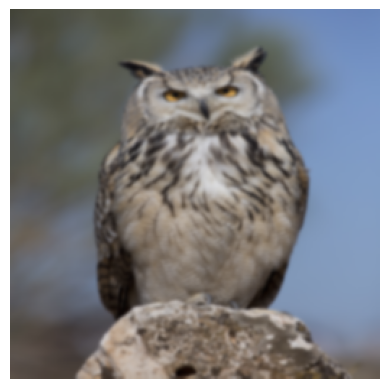

In [ ]:
# displaying after gussian blur
import matplotlib.pyplot as plt
image = images_LR_Gu[879]
plt.imshow(image)
plt.axis('off')
plt.show()

Tried Salt and pepper method to add more noise to the image but it seems didnt work well on our image set

In [ ]:
# Degradation technique - salt and pepper
#Trying to Add more noise by using salt and pepper
#import cv2
#import numpy as np
#import os
#density = 0.01
#def add_salt_and_pepper_noise(image, density):
    #noise_img = np.copy(image)
    #height, width = noise_img.shape[:2]
    #num_pixel = int(height * width * density)

    #salt_pixel = np.random.randint(0, width, num_pixel)
    #pepper_pixel = np.random.randint(0, width, num_pixel)
    #random_rows = np.random.randint(0, height, num_pixel)

    #noise_img[random_rows, salt_pixel] = 100
    #noise_img[random_rows, pepper_pixel] = 0

    #return noise_img


#hr_salt_pepper = '/content/drive/MyDrive/Project/Colab Notebooks/hr_salt'
#HR_deg_dir = '/content/drive/MyDrive/Project/Colab Notebooks/HR_deg'
#os.makedirs(HR_deg_dir, exist_ok=True)

#for i, image in enumerate(resized_images_HR):
   #noisy_hr_image = add_salt_and_pepper_noise(image, density)
   #filename = f'image_{i}.jpg'
   #noisy_image_path = os.path.join(HR_deg_dir, filename)
   #cv2.imwrite(noisy_image_path, noisy_hr_image)



In [ ]:
# downscaling with area - based resampling
scaling_factor = 2  # Scaling
images_LR = []
for image in images_LR_Gu:
    down_image = cv2.resize(image, (128, 128), fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
    images_LR.append(down_image)



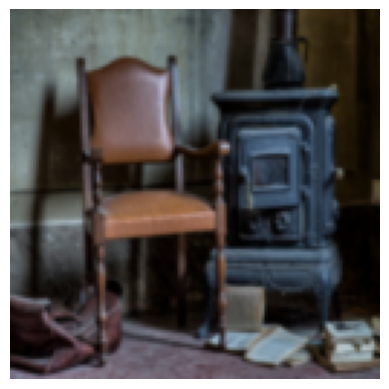

In [ ]:
# displaying after gussian blur and area based
import matplotlib.pyplot as plt
image = images_LR[495]
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# downscaling with bicubic
scaling_factor = 2  # Scaling
images_LR1 = []
for image in images_LR_Gu:
    down_image1 = cv2.resize(image, (128, 128), fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_CUBIC)
    images_LR1.append(down_image1)
    LR_images1 = np.array(images_LR1)

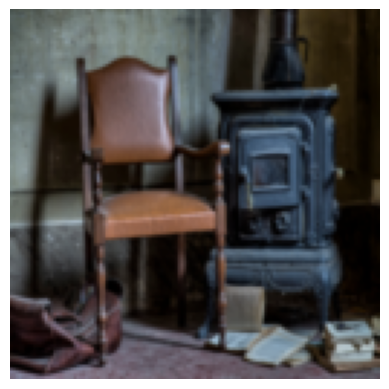

In [ ]:
# displaying after bicubic scaling
import matplotlib.pyplot as plt
image = images_LR1[495]
plt.imshow(image)
plt.axis('off')
plt.show()

Tried downscaling with area-based resampling and bicubic. i have choosed area-resampling over bicubic because **area-based works better**

# EDA for LR images

In [ ]:
# 1) checking Size of LR images
LR_images = np.array(images_LR)
height, width, channels = LR_images.shape[:3]
LR_images.shape

#total 1755 images with 128*128 with 3 channels

(1755, 128, 128, 3)

In [ ]:
# 2) image statistics for LR
#image Statistics for LR image as whole dataset if we want we can calculate for each images from ds
import numpy as np

all_lrimages= np.stack(images_LR, axis=0)

# calculate mean, sd
mean_image = np.mean(all_lrimages, axis=(0, 1, 2))
std_image = np.std(all_lrimages, axis=(0, 1, 2))

print("LR images statistics")
print("Mean for LR:", mean_image)
print("Std for LR:", std_image)

LR images statistics
Mean for LR: [111.79566904 111.14624229 106.14028317]
Std for LR: [69.42656438 66.1542423  71.2082816 ]


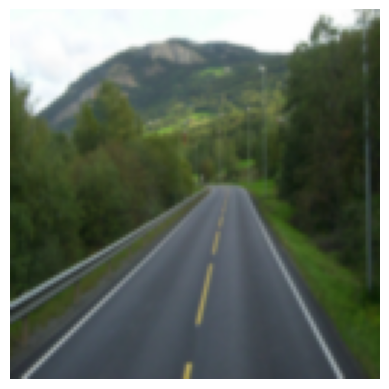

In [ ]:
# 3) visual inspection - manually checking the quality
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
image = images_LR[1004]
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# 3) calculating Spatial Resoultion for whole LR ds
pix_size = 1

tot_edgecount = 0
tot_imagecount = 0

block_si = 13
cons_offset = 2

for image in images_LR:
    gray_image5 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshhold = cv2.threshold(gray_image5, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    eedge = cv2.adaptiveThreshold(gray_image5, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_si, cons_offset)
    eedge_count = cv2.countNonZero(eedge)

    tot_edgecount += eedge_count
    tot_imagecount += 1


    average_spatial_resolutionn = (tot_edgecount / tot_imagecount) / images_LR[0].shape[0] * pix_size

print("Average Spatial Resolution of LR images:", average_spatial_resolutionn)

# Avg distance b/w elements in images


Average Spatial Resolution of LR images: 73.59268162393163


In [ ]:
# 3) Spatial Resoultion for particular LR image

lr_image = images_LR[879]
pixel_si = 1
gray_imagelr = cv2.cvtColor(lr_image, cv2.COLOR_BGR2GRAY)
def calculate_spatial_resolution(lr_image, pixel_si):

    lredges = cv2.Canny(gray_imagelr, 100, 200)
    lredge_count = cv2.countNonZero(lredges)
    lrimage_height = lr_image.shape[0]
    lr_spatial_resolution = (lredge_count / lrimage_height) * pixel_si

    return lr_spatial_resolution


lr_spatial_resolution = calculate_spatial_resolution(lr_image, pixel_si)

print("Spatial Resolution of image 879 from image array:", lr_spatial_resolution)


Spatial Resolution of image 879 from image array: 14.34375


In [ ]:
#4) Nosie analysis for image 879
import numpy as np
import cv2

def calculate_noise(imagel):

  lr_Mean = np.mean(gray_imagelr)
  lr_SD = np.std(gray_imagelr)
  lr_Noise_variance = lr_SD**2
  return lr_Mean, lr_SD, lr_Noise_variance

L_Mean, L_SD, L_Noise_variance = calculate_noise(lr_image)

print(f"Mean Pixel Value of image 879: {L_Mean}")
print(f"Standard Deviation for image 879: {L_SD}")
print(f"Noise Variance for image 879: { L_Noise_variance}")

Mean Pixel Value of image 879: 115.31182861328125
Standard Deviation for image 879: 35.5526127474458
Noise Variance for image 879: 1263.9882731698456


In [ ]:
# 4) noise analysis for LR image dataset
def calculate_noise_variance(image):
    gray_image5 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    Lr_std_dev = np.std(gray_image5)
    Lr_noise_var = Lr_std_dev**2
    return Lr_noise_var

Lr_Noise_variance1 = []
for image in images_LR:
    Lr_noise_var = calculate_noise_variance(image)
    Lr_Noise_variance1.append(Lr_noise_var)
    Lr_Avg_noise_var = np.mean(Lr_Noise_variance1)

print(f"Average Noise Variance of LR image dataset: {Lr_Avg_noise_var}")

Average Noise Variance of LR image dataset: 2908.372108936386


# Visulaization

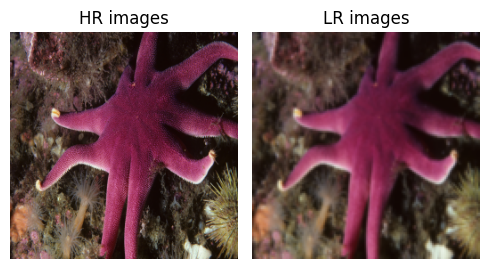

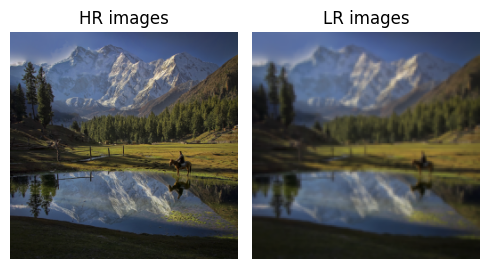

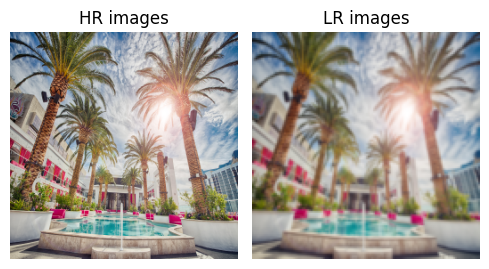

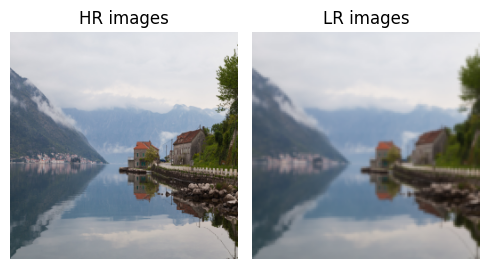

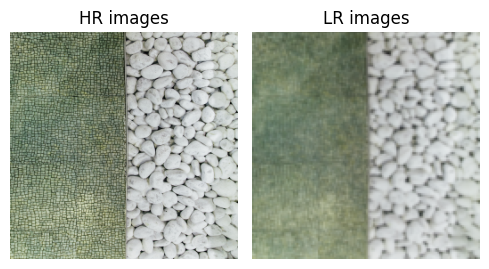

In [ ]:
# image pairing
import matplotlib.pyplot as pt

imgs = 5

for i in range(imgs):
    fig, axes = pt.subplots(1, 2, figsize=(5, 5))

    axes[0].imshow(resized_images_HR[i])
    axes[0].set_title("HR images")
    axes[0].axis("off")

    axes[1].imshow(images_LR[i])
    axes[1].set_title("LR images")
    axes[1].axis("off")

    pt.tight_layout()
    pt.show()


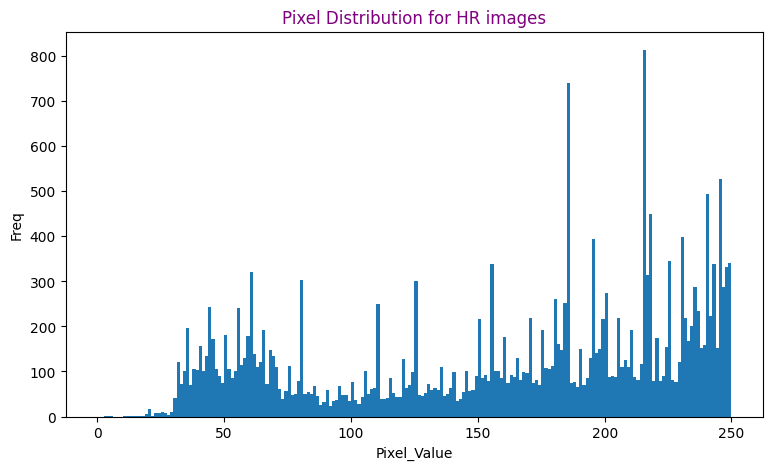

In [ ]:
# pixel value distribution to HR images
fig = pt.figure(figsize=(9,5))
pixel_values = HR_image.flatten()   #convert in to 1D
pt.hist(pixel_values, bins=200, range=(0, 250))

pt.title('Pixel Distribution for HR images', color='purple')
pt.xlabel('Pixel_Value')
pt.ylabel('Freq')
pt.show()

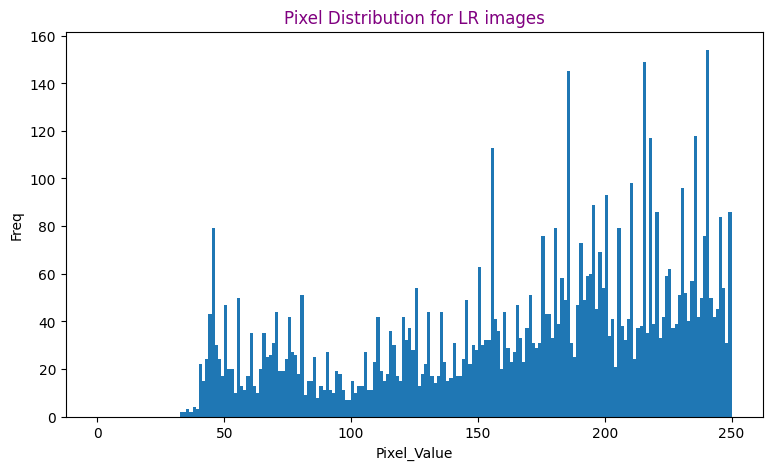

In [ ]:
# pixel value distribution to LR images
fig = pt.figure(figsize=(9,5))
pixel_values =down_image.flatten()   #convert in to 1D
pt.hist(pixel_values, bins=200, range=(0, 250))

pt.title('Pixel Distribution for LR images', color='purple')
pt.xlabel('Pixel_Value')
pt.ylabel('Freq')
pt.show()

# Pre-Processing for HR and LR images

# 1) color correction

In [ ]:
# Color correction for HR and LR images
import cv2
import numpy as np
corr_images_HR = []
corr_images_LR = []

def color_correction(image):
    Rgb_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(Rgb_lab)
    Lab_image= cv2.merge([l_channel, a_channel, b_channel])
    corr_RGB_image = cv2.cvtColor(Lab_image, cv2.COLOR_LAB2RGB)
    return corr_RGB_image

for image in resized_images_HR:
    corrected_image_HR = color_correction(image)
    corr_images_HR.append(corrected_image_HR)

for image in images_LR:
    corrected_image_LR = color_correction(image)
    corr_images_LR.append(corrected_image_LR)


In [ ]:
corr_images_HRr= np.array(corr_images_HR) #coverting into array & checking whether all the HR images got color corrected
height, width, channels = corr_images_HRr.shape[:3]
corr_images_HRr.shape

(1755, 256, 256, 3)

In [ ]:
corr_images_LRr= np.array(corr_images_LR) #coverting into array & checking whether all the LR images got color corrected
height, width, channels = corr_images_LRr.shape[:3]
corr_images_LRr.shape

(1755, 128, 128, 3)

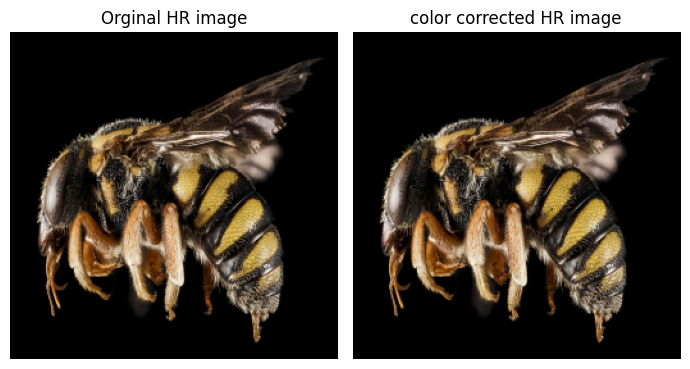

In [ ]:
# Displaying original HR image and color corrected image for analysis
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow(resized_images_HR[100])
axes[0].set_title("Orginal HR image")
axes[0].axis("off")

axes[1].imshow(corr_images_HR[100])
axes[1].set_title("color corrected HR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

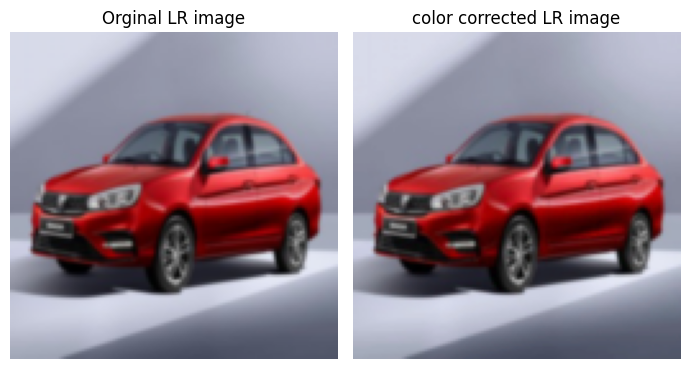

In [ ]:
# Displaying original LR image and color corrected image for analysis
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow(images_LR[1600])
axes[0].set_title("Orginal LR image")
axes[0].axis("off")

axes[1].imshow(corr_images_LR[1600])
axes[1].set_title("color corrected LR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

# 2) Sharpning

In [ ]:
# sharpning color corrected HR and LR images
sharp_HR_images = []
sharp_LR_images = []

def sharpen_images(images):
     sharp_images=[]

     for image in images:
        blurred_images = cv2.GaussianBlur(image, (0, 0), 3)
        sharpened_images = cv2.addWeighted(image, 1.5, blurred_images, -0.5, 0)
        sharp_images.append(sharpened_images)

     return sharp_images

sharp_HR_images = sharpen_images(corr_images_HR)
sharp_LR_images = sharpen_images(corr_images_LR)

In [ ]:
Sharp_HR= np.array(sharp_HR_images) #coverting into array & checking whether all the HR images got sharpend
Sharp_HR.shape

(1755, 256, 256, 3)

In [ ]:
Sharp_LR= np.array(sharp_LR_images) #coverting into array & checking whether all the LR images got sharpend
Sharp_LR.shape

(1755, 128, 128, 3)

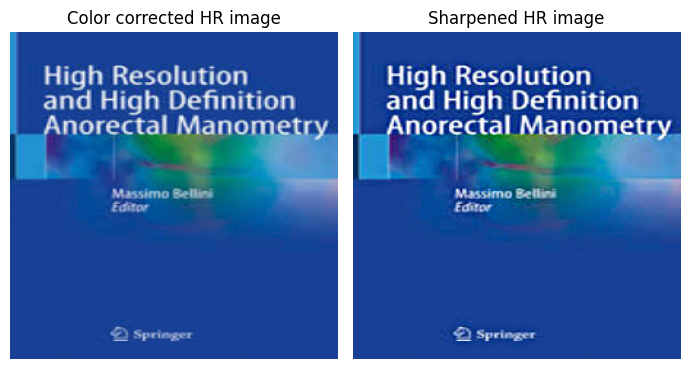

In [ ]:
# displaying sharppened HR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( corr_images_HR[1745])
axes[0].set_title("Color corrected HR image")
axes[0].axis("off")

axes[1].imshow(sharp_HR_images [1745])
axes[1].set_title("Sharpened HR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

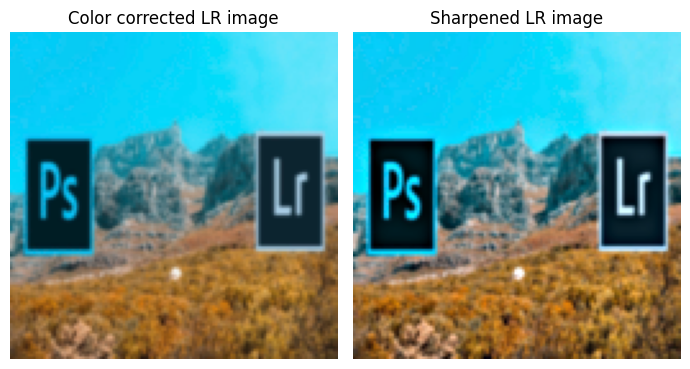

In [ ]:
# displaying sharppened LR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( corr_images_LR[1724])
axes[0].set_title("Color corrected LR image")
axes[0].axis("off")

axes[1].imshow(sharp_LR_images [1724])
axes[1].set_title("Sharpened LR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

# 3) contract enhancement

In [ ]:
#contrast enhancement using Gamma Correction
import numpy as np

def enhance_contrast(image, gamma=1.0):
  enhance_images=[]
  for image in image:
     enhance_image= np.power(image/255.0, gamma)*255.0
     enhance_image = np.array(enhance_image, dtype=np.uint8)
     enhance_images.append(enhance_image)
  return enhance_images

con_HR_images = enhance_contrast(sharp_HR_images )
con_LR_images = enhance_contrast(sharp_LR_images )


In [ ]:
Con_HR= np.array(con_HR_images) #coverting into array & checking whether all the HR images got contrast enhancement
Con_HR.shape

(1755, 256, 256, 3)

In [ ]:
Con_LR= np.array(con_LR_images) #coverting into array & checking whether all the LR images got contrast enhancement
Con_LR.shape

(1755, 128, 128, 3)

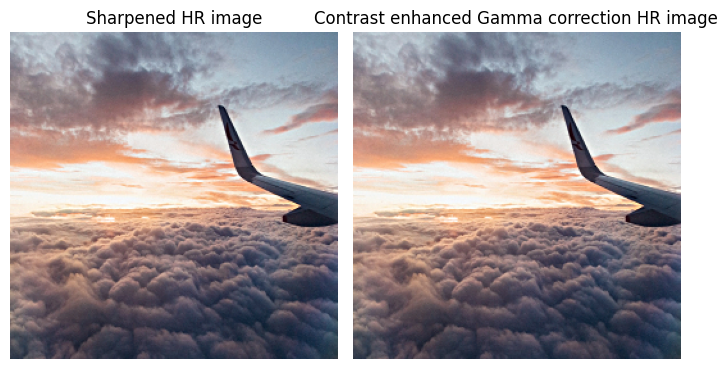

In [ ]:
# displaying contrast enhanced HR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( sharp_HR_images[1722])
axes[0].set_title("Sharpened HR image")
axes[0].axis("off")

axes[1].imshow(Con_HR [1722])
axes[1].set_title("Contrast enhanced Gamma correction HR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

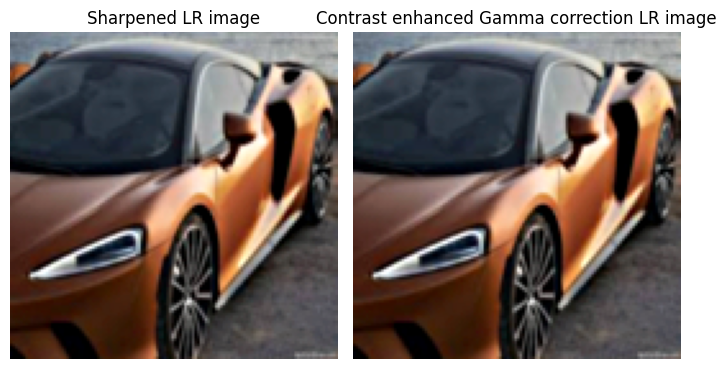

In [ ]:
# displaying contrast enhanced HR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( sharp_LR_images[1702])
axes[0].set_title("Sharpened LR image")
axes[0].axis("off")

axes[1].imshow(Con_LR [1702])
axes[1].set_title("Contrast enhanced Gamma correction LR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

In [ ]:
#contrast enhancement - CLAHE
import cv2
import numpy as np

def enhance_contrastt(images, clip_limit=0.5, tile_grid_size=(8, 8)):
    enha_images = []
    for image in images:
        cov_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(cov_lab)

        clahe_image = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        lab_img = clahe_image.apply(l)

        enhance_labimg = cv2.merge((lab_img, a, b))
        cov_rgb = cv2.cvtColor(enhance_labimg, cv2.COLOR_LAB2RGB)

        enha_images.append(cov_rgb)

    return enha_images

contrast_HR = enhance_contrastt(sharp_HR_images)
contrast_LR = enhance_contrastt(sharp_LR_images)

In [ ]:
Cont_HR= np.array(contrast_HR) #coverting into array & checking whether all the HR images got contrast enhancement
Cont_HR.shape

(1755, 256, 256, 3)

In [ ]:
Cont_LR= np.array(contrast_LR) #coverting into array & checking whether all the HR images got contrast enhancement
Cont_LR.shape

(1755, 128, 128, 3)

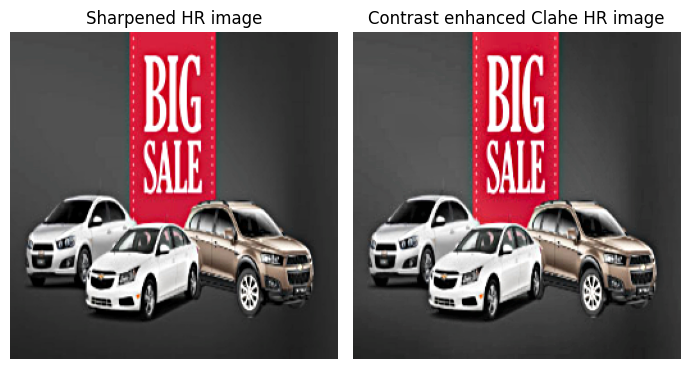

In [ ]:
# displaying contrast enhanced HR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( sharp_HR_images[1681])
axes[0].set_title("Sharpened HR image")
axes[0].axis("off")

axes[1].imshow(Cont_HR [1681])
axes[1].set_title("Contrast enhanced Clahe HR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

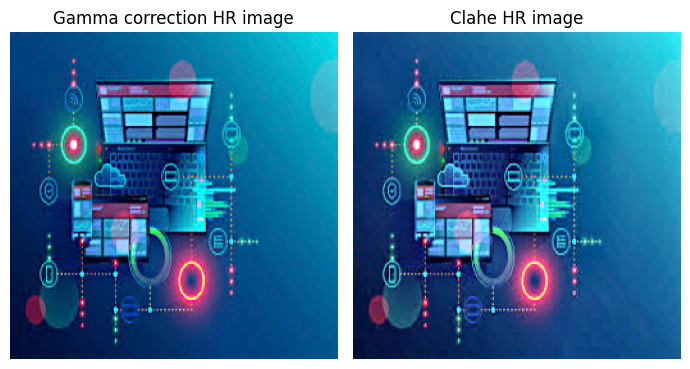

In [ ]:
# Comparing gamma and clahe HR
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow(Con_HR [1676])
axes[0].set_title("Gamma correction HR image")
axes[0].axis("off")

axes[1].imshow(Cont_HR [1676])
axes[1].set_title("Clahe HR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

# Gamma seems to be working better than CLAHE for below picture for other images both seams ok

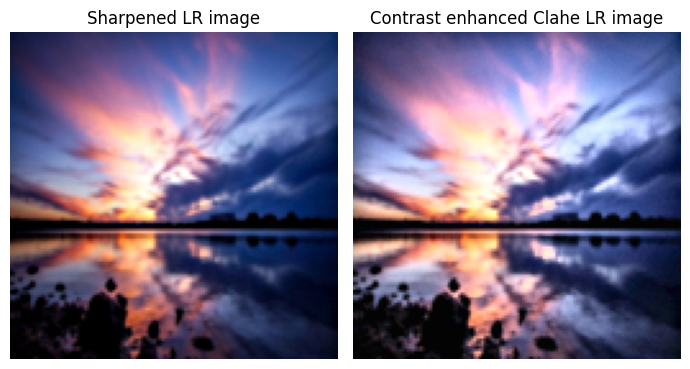

In [ ]:
# displaying contrast enhanced LR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( sharp_LR_images[1665])
axes[0].set_title("Sharpened LR image")
axes[0].axis("off")

axes[1].imshow(Cont_LR [1665])
axes[1].set_title("Contrast enhanced Clahe LR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

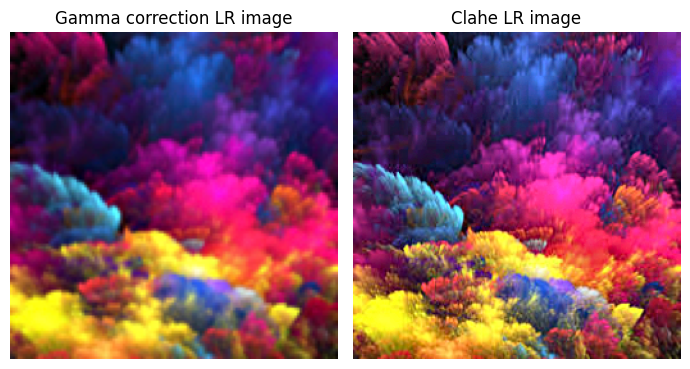

In [ ]:
# Comparing gamma and clahe LR
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow(Con_LR [1668])
axes[0].set_title("Gamma correction LR image")
axes[0].axis("off")

axes[1].imshow(Cont_HR [1668])
axes[1].set_title("Clahe LR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

# Gamma seems to be working better than CLAHE for below picture. if you see clahe reducecs the blurring effect and ads more contrast

In [ ]:
# contrast enhancement using Gamma correction, clahe were implemented.
# Gamma is working better than clahe


# 4) color jittering

we can skip this step since its not working properly on some images. this color jittering process is not suitable for our dataset.

In [ ]:
# color jittering for both HR and LR
#color jittering for contrast enhanced images ( gamma correction images)
#convert RGB to HSV -> perform jittering -> convert back to HSV to RGB
import cv2
import numpy as np

def color_jitter(images, brightness_range=(-10, 10), contrast_range=(0.8, 1.0), saturation_range=(0.3, 0.6), hue_range=(-8, 8)):

    jit_image= []
    for image in images:
        hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        brightness = np.random.randint(brightness_range[0], brightness_range[1]+1) # adjusting brightness, contrast, saturation, hue
        contrast = np.random.uniform(contrast_range[0], contrast_range[1])
        saturation = np.random.uniform(saturation_range[0], saturation_range[1])
        hue = np.random.randint(hue_range[0], hue_range[1]+1)

        hsv_img[..., 2] = np.clip(hsv_img[..., 2] + brightness, 0, 255) #color jittering #applying brightness to channel 2 of HSV
        hsv_img[..., 1] = np.clip(hsv_img[..., 1] * contrast, 0, 255) # contrast for channel 1
        hsv_img[..., 1] = np.clip(hsv_img[..., 1] * saturation, 0, 255) # saturation for channel 1
        hsv_img[..., 0] = (hsv_img[..., 0] + hue) % 180 # hue channel 0

        RGB_image= cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

        jit_image.append(RGB_image)

    return jit_image

CT_HR_image = color_jitter(con_HR_images)
CT_LR_image = color_jitter(con_LR_images)


In [ ]:
CT_HR= np.array(CT_HR_image) #coverting into array & checking whether all the HR images got jittered
CT_HR.shape

(1755, 256, 256, 3)

In [ ]:
CT_LR= np.array(CT_LR_image) #coverting into array & checking whether all the LR images got jittered
CT_LR.shape

(1755, 128, 128, 3)

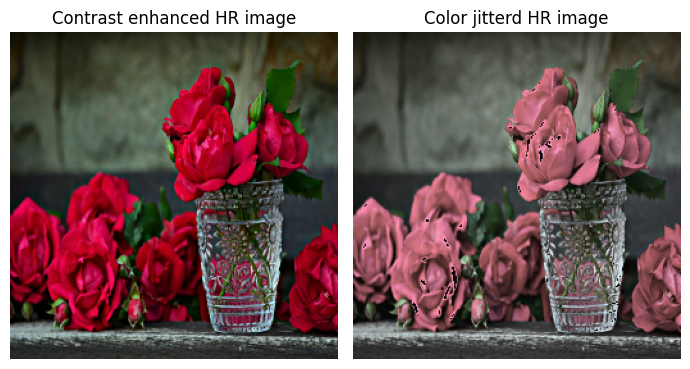

In [ ]:
# displaying color jittered HR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( Con_HR [703])
axes[0].set_title("Contrast enhanced HR image")
axes[0].axis("off")

axes[1].imshow(CT_HR[703])
axes[1].set_title("Color jitterd HR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

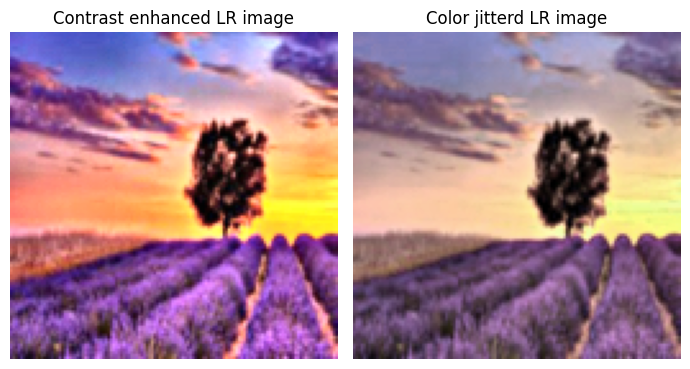

In [ ]:
# displaying color jittered LR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( Cont_LR [1657])
axes[0].set_title("Contrast enhanced LR image")
axes[0].axis("off")

axes[1].imshow(CT_LR[1657])
axes[1].set_title("Color jitterd LR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

In [ ]:
# color jittering for Gamma correction works poorly but for some pictures its not applied properly
# will try to do color jittering for clahe images

In [ ]:
# color jittering for both HR and LR
#color jittering for contrast enhanced images ( Clahe images)
#convert RGB to HSV -> perform jittering -> convert back to HSV to RGB
import cv2
import numpy as np

def color_jitter(images, brightness_range=(-20, 20), contrast_range=(0.8, 1.2), saturation_range=(0.8, 1.2), hue_range=(-10, 10)):


    jit_image= []
    for image in images:
        hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        brightness = np.random.randint(brightness_range[0], brightness_range[1]+1) # adjusting brightness, contrast, saturation, hue
        contrast = np.random.uniform(contrast_range[0], contrast_range[1])
        saturation = np.random.uniform(saturation_range[0], saturation_range[1])
        hue = np.random.randint(hue_range[0], hue_range[1]+1)

        hsv_img[..., 2] = np.clip(hsv_img[..., 2] + brightness, 0, 255) #color jittering #applying brightness to channel 2 of HSV
        hsv_img[..., 1] = np.clip(hsv_img[..., 1] * contrast, 0, 255) # contrast for channel 1
        hsv_img[..., 1] = np.clip(hsv_img[..., 1] * saturation, 0, 255) # saturation for channel 1
        hsv_img[..., 0] = (hsv_img[..., 0] + hue) % 180 # hue channel 0

        RGB_image= cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

        jit_image.append(RGB_image)

    return jit_image

CT_HR_image = color_jitter(contrast_HR)
CT_LR_image = color_jitter(contrast_LR)


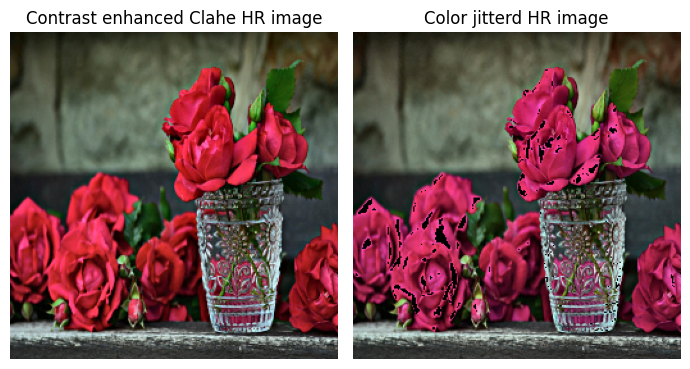

In [ ]:
# displaying color jittered HR images for visualization
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow( Cont_HR [703])
axes[0].set_title("Contrast enhanced Clahe HR image")
axes[0].axis("off")

axes[1].imshow(CT_HR_image[703])
axes[1].set_title("Color jitterd HR image")
axes[1].axis("off")

pt.tight_layout()
pt.show()

In [ ]:
# color jittering for clahe images is also not working properly
# so we can leave this step becuz gamma correction images looks better than clahe, color jitterd images.
# tried changing ranges of color jitter still same.

# 4) Artifact removal
Denoising - removing noise from both HR and LR



In [ ]:
#denoising with Bilateral filter and total variation and NLP Denoising
import numpy as np
import cv2
from skimage.restoration import denoise_tv_chambolle
from skimage.restoration import denoise_nl_means

def bilateral_filter_total(image, d, sigma_color, sigma_space, weight_tv):
    denoised_images = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    total_denoised = denoise_tv_chambolle(denoised_images, weight=weight_tv)
    return total_denoised

def nlm_denoising(image, h, patch_size, patch_distance):
  denoised_image = denoise_nl_means(image, h=h, patch_size=patch_size, patch_distance=patch_distance)
  return denoised_image

De_HR_images=[]
for img in De_HR_images:
    denoised_image = bilateral_filter_total(img, 25, 8, 4,0.7)
    denoised_image = nlm_denoising(denoised_image, h=0.6, patch_size=29, patch_distance=5)
    De_HR_images.append(denoised_image)


De_LR_images=[]
for imge in De_LR_images:
    denoised_image = bilateral_filter_total(imge, 25, 8, 4 ,0.7)
    denoised_image = nlm_denoising(denoised_image, h=0.6, patch_size=29, patch_distance=5)
    De_LR_images.append(denoised_image)

De_HR_images = enhance_contrast(con_HR_images )
De_LR_images = enhance_contrast(con_LR_images )

In [ ]:
De_HR= np.array(De_HR_images) #coverting into array & checking whether all the HR images got denoised
De_HR.shape

(1755, 256, 256, 3)

In [ ]:
De_LR= np.array(De_LR_images) #coverting into array & checking whether all the HR images got denoised
De_LR.shape

(1755, 128, 128, 3)

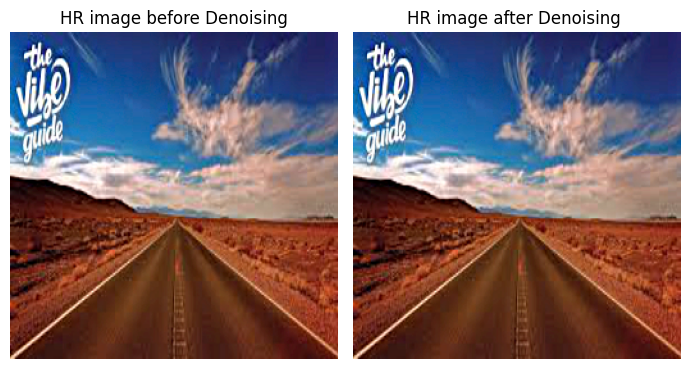

In [ ]:
# displaying HR image before and after denoising
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow(Con_HR [1548])
axes[0].set_title("HR image before Denoising")
axes[0].axis("off")

axes[1].imshow(De_HR [1548])
axes[1].set_title("HR image after Denoising ")
axes[1].axis("off")

pt.tight_layout()
pt.show()

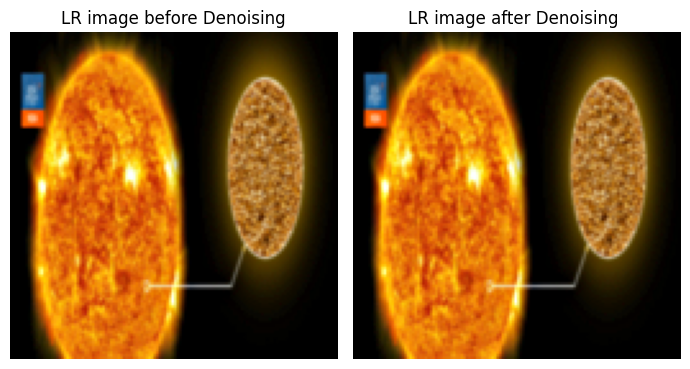

In [ ]:
# displaying LR image before and after denoising
import matplotlib.pyplot as pt

fig, axes = pt.subplots(1, 2, figsize=(7, 7))

axes[0].imshow(Con_LR [1559])
axes[0].set_title("LR image before Denoising")
axes[0].axis("off")

axes[1].imshow(De_LR [1559])
axes[1].set_title("LR image after Denoising ")
axes[1].axis("off")

pt.tight_layout()
pt.show()

In [ ]:
# Noise Variance for HR
import numpy as np
import cv2
image=De_HR[879]

def calculate_noise(image):
  gray_pic= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  Mean = np.mean(gray_pic)
  SD = np.std(gray_pic)
  Noise_variance = SD**2
  return Mean, SD, Noise_variance

Mean, SD, Noise_variance = calculate_noise(image)

print(f"Mean Pixel Value of image 879: {Mean}")
print(f"Standard Deviation for image 879: {SD}")
print(f"Noise Variance for image 879: { Noise_variance}")

Mean Pixel Value of image 879: 115.36723327636719
Standard Deviation for image 879: 43.50882864564658
Noise Variance for image 879: 1893.0181701162364


In [ ]:
# Noise Variance for LR
import numpy as np
import cv2
image=De_LR[879]

def calculate_noise(image):
  gray_picc= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  Mean = np.mean(gray_picc)
  SD = np.std(gray_picc)
  Noise_variance = SD**2
  return Mean, SD, Noise_variance

Mean, SD, Noise_variance = calculate_noise(image)

print(f"Mean Pixel Value of image 879: {Mean}")
print(f"Standard Deviation for image 879: {SD}")
print(f"Noise Variance for image 879: { Noise_variance}")

Mean Pixel Value of image 879: 115.458984375
Standard Deviation for image 879: 40.40035427240327
Noise Variance for image 879: 1632.1886253356931


# Normalization


In [ ]:
import numpy as np

# Normalize pixel values of HR images
normalized_HR_images = []
for hr_image in con_HR_images:
    normalized_image = (hr_image.astype(np.float32) - np.min(hr_image)) / (np.max(hr_image) - np.min(hr_image))
    normalized_HR_images.append(normalized_image)

# Normalize pixel values of LR images
normalized_LR_images = []
for lr_image in con_LR_images:
    normalized_image = (lr_image.astype(np.float32) - np.min(lr_image)) / (np.max(lr_image) - np.min(lr_image))
    normalized_LR_images.append(normalized_image)


In [ ]:
Nor_HR= np.array(normalized_HR_images) #coverting into array & checking whether all the HR images got normalised
Nor_HR.shape

(1755, 256, 256, 3)

In [ ]:
Nor_LR= np.array(normalized_LR_images) #coverting into array & checking whether all the HR images got normalised
Nor_LR.shape

(1755, 128, 128, 3)

In [ ]:
# checking 807th HR image from HR normalized data
# checking whether above normalization is performed on HR image dataset
normalized_image = normalized_HR_images[807]

mean = np.mean(normalized_image)
standard= np.std(normalized_image)

print(f"Mean of HR normalized 807th image: {mean}")
print(f"Standard Deviation for 807th normalized HR image: {standard}")

Mean of HR normalized 807th image: 0.36440643668174744
Standard Deviation for 807th normalized HR image: 0.2918540835380554


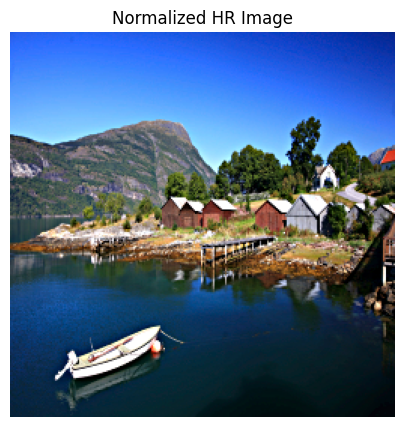

In [ ]:
#normalization image output
import matplotlib.pyplot as pt
fig = pt.figure(figsize=(5,5))
norm_image= normalized_HR_images [807]
if norm_image.ndim == 3 and norm_image.shape[0] == 1:
    norm_image = norm_image.squeeze()
pt.imshow(norm_image)
pt.title("Normalized HR Image")
pt.axis('off')
pt.show()

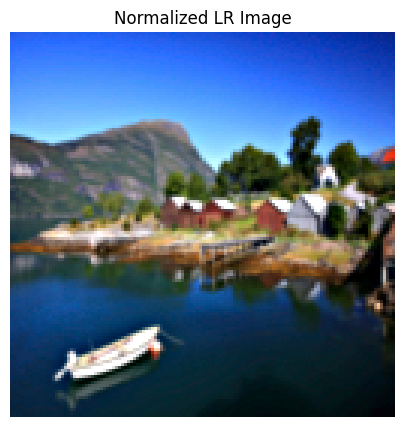

In [ ]:
#normalization LR image output
import matplotlib.pyplot as pt
fig = pt.figure(figsize=(5,5))
norm_image= normalized_LR_images [807]
if norm_image.ndim == 3 and norm_image.shape[0] == 1:
    norm_image = norm_image.squeeze()
pt.imshow(norm_image)
pt.title("Normalized LR Image")
pt.axis('off')
pt.show()

**HR image before and after normalization**

In [ ]:
# checking 807th HR image from HR data before normalization
normal_image = resized_images_HR[807]

mean = np.mean(normal_image )
standard = np.std(normal_image )

print(f"Mean of HR 807th image before normalization: {mean}")
print(f"Standard Deviation for 807th HR image before normalization: {standard}")

Mean of HR 807th image before normalization: 93.24051920572917
Standard Deviation for 807th HR image before normalization: 71.41452880156233


In [ ]:
# checking 807th HR image from HR normalized data
# checking whether above normalization is performed on HR image dataset
normalized_image = normalized_HR_images[807]

mean = np.mean(normalized_image)
standard= np.std(normalized_image)

print(f"Mean of HR normalized 807th image: {mean}")
print(f"Standard Deviation for 807th normalized HR image: {standard}")

# after normalization pixel value of image 807 from normalized HR images has changed to lower range indicates standard distribution

Mean of HR normalized 807th image: 0.36440643668174744
Standard Deviation for 807th normalized HR image: 0.2918540835380554


**LR image before and after normalization**

In [ ]:
# checking 807th LR image from LR data before normalization

normal_image = LR_images[807]

mean = np.mean(normal_image )
standard = np.std(normal_image )

print(f"Mean of LR 807th image before normalization: {mean}")
print(f"Standard Deviation for 807th LR image before normalization: {standard}")

Mean of LR 807th image before normalization: 93.3726806640625
Standard Deviation for 807th LR image before normalization: 69.04359352404667


In [ ]:
# checking 807th LR image from LR normalized data
# checking whether above normalization is performed on LR image dataset
normalized_image = normalized_LR_images[807]

mean = np.mean(normalized_image)
standard= np.std(normalized_image)

print(f"Mean of LR 807th image before normalization: {mean}")
print(f"Standard Deviation for 807th LR image before normalization: {standard}")

Mean of LR 807th image before normalization: 0.36487671732902527
Standard Deviation for 807th LR image before normalization: 0.2851793169975281


In [ ]:
hr_image = normalized_HR_images[0]
lr_image = normalized_LR_images[0]

hr_channels = hr_image.shape[-1]  # Number of channels in HR image
lr_channels = lr_image.shape[-1]  # Number of channels in LR image

print("Number of channels in HR image:", hr_channels)
print("Number of channels in LR image:", lr_channels)

Number of channels in HR image: 3
Number of channels in LR image: 3


# Downloading HR and LR images

In [ ]:
import os
import cv2
import numpy as np
import os

directory_path = '/content/drive/MyDrive/Project/Colab Notebooks'
directory_name = 'preprocessed_images'
os.makedirs(os.path.join(directory_path, directory_name), exist_ok=True)


In [ ]:
import os
import cv2

def convert_and_save_images(image_set, directory_path, format='png'):
    os.makedirs(directory_path, exist_ok=True)
    for i, image in enumerate(image_set):
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        scaled_image = (rgb_image * 255).astype(np.uint8)  # Scale the normalized image back to 0-255

        filename = f"Image_{i}.{format}"
        filepath = os.path.join(directory_path, filename)
        cv2.imwrite(filepath, scaled_image)
        print(f"Saved image {i+1}/{len(image_set)} as {format.upper()}")

directory_path = '/content/drive/MyDrive/Project/Colab Notebooks/preprocessed_images'
convert_and_save_images(normalized_HR_images, os.path.join(directory_path, "HR_pre"), format='png')


Saved image 1/1755 as PNG
Saved image 2/1755 as PNG
Saved image 3/1755 as PNG
Saved image 4/1755 as PNG
Saved image 5/1755 as PNG
Saved image 6/1755 as PNG
Saved image 7/1755 as PNG
Saved image 8/1755 as PNG
Saved image 9/1755 as PNG
Saved image 10/1755 as PNG
Saved image 11/1755 as PNG
Saved image 12/1755 as PNG
Saved image 13/1755 as PNG
Saved image 14/1755 as PNG
Saved image 15/1755 as PNG
Saved image 16/1755 as PNG
Saved image 17/1755 as PNG
Saved image 18/1755 as PNG
Saved image 19/1755 as PNG
Saved image 20/1755 as PNG
Saved image 21/1755 as PNG
Saved image 22/1755 as PNG
Saved image 23/1755 as PNG
Saved image 24/1755 as PNG
Saved image 25/1755 as PNG
Saved image 26/1755 as PNG
Saved image 27/1755 as PNG
Saved image 28/1755 as PNG
Saved image 29/1755 as PNG
Saved image 30/1755 as PNG
Saved image 31/1755 as PNG
Saved image 32/1755 as PNG
Saved image 33/1755 as PNG
Saved image 34/1755 as PNG
Saved image 35/1755 as PNG
Saved image 36/1755 as PNG
Saved image 37/1755 as PNG
Saved imag

In [ ]:
import os
import cv2

def convert_and_save_images(image_set, directory_path, format='png'):
    os.makedirs(directory_path, exist_ok=True)
    for i, image in enumerate(image_set):
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        scaled_image = (rgb_image * 255).astype(np.uint8)  # Scale the normalized image back to 0-255

        filename = f"Image_{i}.{format}"
        filepath = os.path.join(directory_path, filename)
        cv2.imwrite(filepath, scaled_image)
        print(f"Saved image {i+1}/{len(image_set)} as {format.upper()}")

directory_path = '/content/drive/MyDrive/Project/Colab Notebooks/preprocessed_images'
convert_and_save_images(normalized_LR_images, os.path.join(directory_path, "LR_pre"), format='png')



Saved image 1/1755 as PNG
Saved image 2/1755 as PNG
Saved image 3/1755 as PNG
Saved image 4/1755 as PNG
Saved image 5/1755 as PNG
Saved image 6/1755 as PNG
Saved image 7/1755 as PNG
Saved image 8/1755 as PNG
Saved image 9/1755 as PNG
Saved image 10/1755 as PNG
Saved image 11/1755 as PNG
Saved image 12/1755 as PNG
Saved image 13/1755 as PNG
Saved image 14/1755 as PNG
Saved image 15/1755 as PNG
Saved image 16/1755 as PNG
Saved image 17/1755 as PNG
Saved image 18/1755 as PNG
Saved image 19/1755 as PNG
Saved image 20/1755 as PNG
Saved image 21/1755 as PNG
Saved image 22/1755 as PNG
Saved image 23/1755 as PNG
Saved image 24/1755 as PNG
Saved image 25/1755 as PNG
Saved image 26/1755 as PNG
Saved image 27/1755 as PNG
Saved image 28/1755 as PNG
Saved image 29/1755 as PNG
Saved image 30/1755 as PNG
Saved image 31/1755 as PNG
Saved image 32/1755 as PNG
Saved image 33/1755 as PNG
Saved image 34/1755 as PNG
Saved image 35/1755 as PNG
Saved image 36/1755 as PNG
Saved image 37/1755 as PNG
Saved imag